In [2]:
%load_ext autoreload
%autoreload 1
import os
from datetime import timedelta

import numpy as np
import obspy
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from obspy import UTCDateTime
from seispy.decon import RFTrace

from insight.util import TraceFile, snr
from insight.util import trace_slice


# Load Data

In [3]:
DATA_DIR = "../data/"
CAT_FILE = "a_quality.parquet"
events = ["S1222a", "S1094b", "S1000a", "S1133c", "S1102a"]
network, station, location = "XB", "ELYSE", "02"
img_prf = np.asarray(Image.open("../img/S1222a_PRF_0.25-1.0_g2.png"))

syn_x, syn_y = np.load("../data/synthetic.npy")

# Detrend & Bandpass

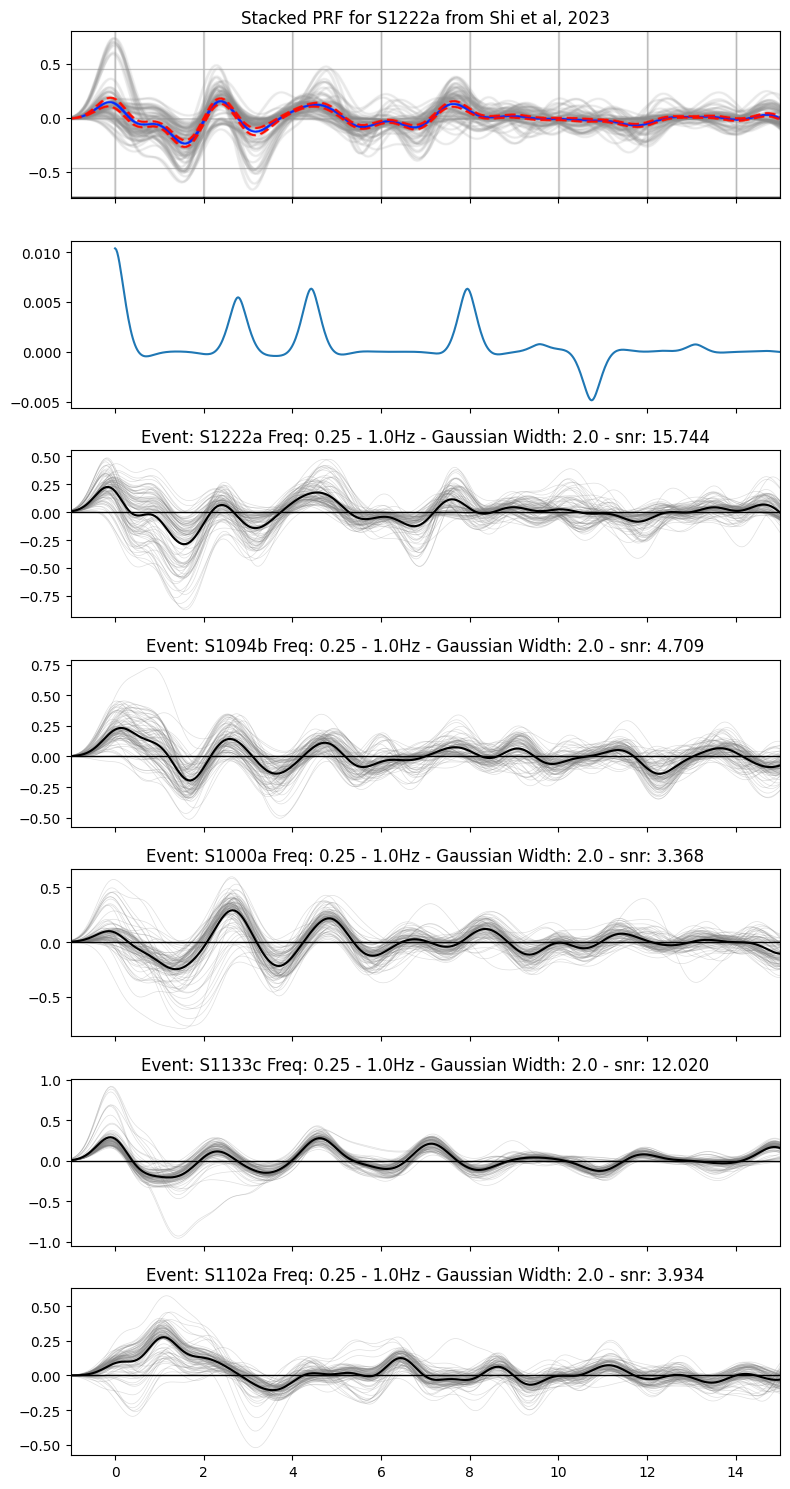

In [4]:
def trace_plot(axes: Axes, trace: obspy.Trace, start=10, end=40, t_offset=10, y_offset=0, plt_args={}):
    sliced = trace_slice(start, end, trace)
    times = sliced.times(type="relative")
    times -= t_offset
    data = sliced.data + y_offset
    axes.plot(times, data, **plt_args)


def rf_plot(axes: Axes, rf: RFTrace, start=0, end=40, t_offset=10, invert_y=False):
    sliced = trace_slice(start, end, rf)
    times = sliced.times(type="relative")
    times -= t_offset
    data = sliced.data
    data *= -1 if invert_y else 1
    axes.plot(times, data, linewidth=0.5, color='k')
    axes.fill_between(times, data, where=(data > 0), color='red', alpha=.3)
    axes.fill_between(times, data, where=(data < 0), color='blue', alpha=.3)

rf_start = 10
gauss_width = 2.0

fig, axs = plt.subplots(len(events) + 2, 1, figsize=(8, len(events) * 3), dpi=100, sharex="col")
mean_prfs = {}
snr_vals = {}

for i in range(len(events)):
    evt_id = events[i]
    event = pd.read_parquet(os.path.join(DATA_DIR, CAT_FILE)).loc[evt_id]
    trace_file = TraceFile(network, station, location, event.id)
    st = obspy.read(os.path.join(DATA_DIR, "zne", str(trace_file)))
    ax = axs[i + 2]
    
    bandpass = {"freqmin": 0.25, "freqmax": 1.0, "corners": 4, "zerophase": True}
    st_zrt = st.copy().rotate(method="NE->RT", back_azimuth=event.mqs_azimuth)
    st_zrt_filtered = st_zrt.copy()
    st_zrt_filtered.detrend()
    st_zrt_filtered.filter(type="highpass", freq=0.01)
    st_zrt_filtered.filter(type="bandpass", **bandpass)
    snr_vals[evt_id] = snr(UTCDateTime(event.arrival), 10.0, st_zrt_filtered.select(component="Z")[0])
    
    series = []
    for window in np.arange(15, 100 + rf_start + 1, 1):
        st_sliced = st_zrt_filtered.slice(UTCDateTime(event.arrival - timedelta(seconds=rf_start)),
                                          UTCDateTime(event.arrival + timedelta(seconds=int(window) + rf_start)))
        rf = RFTrace.deconvolute(
            utr=st_sliced.select(component="R")[0],  # utr = numerator (radial for PdS)
            wtr=st_sliced.select(component="Z")[0],  # wtr = denominator (vertical component for PdS)
            tshift=rf_start,  # tshift = Time until beginning of receiver function (s)
            f0=gauss_width,  # f0 = width of gaussian filter
            itmax=500,  # itmax = max # iterations
            minderr=0.0001,  # Min change in error required for stopping iterations
        )
        series.append(rf.data)
        times = rf.times(type="relative") - rf_start
        trace_plot(ax, rf, start=0, end=25, t_offset=rf_start,
                   plt_args={"label": str(window), "color": ".5", "linewidth": 0.5, "alpha": 0.25})
    
    # Calculate mean RF
    shortest_rf = min([len(s) for s in series])
    avg_rf = np.zeros(shortest_rf)
    for i in series:
        avg_rf += i[:shortest_rf]
    avg_rf /= len(series)
    mean_prfs[evt_id] = avg_rf
    ax.axhline(0, color="k", linewidth=1)
    ax.plot(times[:shortest_rf], avg_rf, color="k")
    ax.set_title(f"Event: {evt_id} Freq: {bandpass['freqmin']} - {bandpass['freqmax']}Hz - Gaussian Width: {gauss_width} - snr: {snr_vals[evt_id]:0.3f}")
    ax.set_xlim(-1, 15)

axs[0].imshow(img_prf, extent=(-2, 15, -.75, .8), aspect="auto")
axs[0].set_title("Stacked PRF for S1222a from Shi et al, 2023")
axs[1].plot(syn_x, syn_y)
fig.tight_layout()


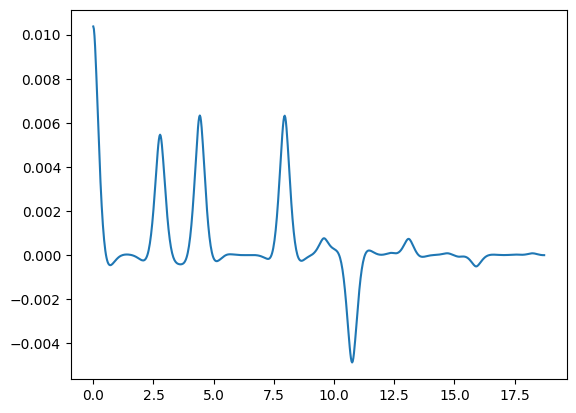

In [5]:
plt.plot(syn_x, syn_y)

In [13]:
modelled_df = pd.DataFrame(index=times[:shortest_rf])
for evt_id in mean_prfs.keys():
    modelled_df[evt_id] = mean_prfs[evt_id]
    
modelled_df.to_parquet(os.path.join(DATA_DIR, "prfs/modelled.parquet"))

In [12]:
modelled_df.tail()

,S1222a,S1094b,S1000a,S1133c,S1102a
24.80,0.045417,0.013482,-0.006027,0.041292,0.062110
24.85,0.040857,0.006948,-0.002391,0.040533,0.060946
24.90,0.036343,0.000287,0.000337,0.038774,0.059883
24.95,0.032106,-0.006436,0.002218,0.036185,0.058827
25.00,0.028332,-0.013149,0.003353,0.032978,0.057645
